In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2021-12-29 19:28:52.876981: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-29 19:28:52.877094: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-29 19:28:57.707911: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-29 19:28:57.711171: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-29 19:28:57.711214: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-29 19:28:57.711249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5aee23d67f4b): /proc/driver/nvidia/version does not exist
2021-12-29 19:28:57.718871: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [3]:
from transformers import BertTokenizer, TFBertModel, AutoTokenizer,TFAutoModel
import tensorflow as tf

In [4]:
# model_roBerta ='joeddav/xlm-roberta-large-xnli'
model_Bert = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_Bert)
model = TFBertModel.from_pretrained(model_Bert)
model.summary()

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  177853440 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [5]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')

In [6]:
train[10:]

,id,keyword,location,text,target
10,16,NaN,NaN,Three people died from the heat wave so far,1
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT ...,1
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1
13,19,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1
14,20,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
x_train = pd.DataFrame(train, columns = {'id','text'})
#y_train = pd.DataFrame(train, columns = {'target'})
y_train = train[['target']]

In [8]:
import re
import string
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('ûò', '', text)
    return text
x_train.text = x_train.text.apply(lambda x: remove_noise(x))
x_train.head()

,text,id
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask Canada,4
2,All residents asked to shelter in place are be...,5
3,people receive wildfires evacuation orders in...,6
4,Just got sent this photo from Ruby Alaska as s...,7


In [9]:
SEQ_LEN = 100 #len(x_train['text'])  # 236#max(train.astype('str').applymap(lambda x: len(x)).max())

def bert_encode(df, tokenizer):    
    batch_tweets = df['text'].tolist()
    
    tokens = tokenizer(batch_tweets, max_length = SEQ_LEN,
                   truncation=True, padding='max_length',
                   add_special_tokens=True, return_attention_mask=True,
                   return_token_type_ids=True, #only for BERT
                   return_tensors='tf')
    #tokens['input_ids'] = tf.reshape(tokens['input_ids'], [7613, 10, 10])
    #tokens['attention_mask'] = tf.reshape(tokens['attention_mask'], [7613, 10, 10])
    #tokens['token_type_ids'] = tf.reshape(tokens['token_type_ids'], [7613, 10, 10])
    inputs = {
          'input_ids': tokens['input_ids'], 
          'attention_mask': tokens['attention_mask'],
           'token_type_ids': tokens['token_type_ids']  
    } #  only for BERT
    return inputs

In [10]:
x_train_input = bert_encode(x_train, tokenizer)
x_train_input # = tf.reshape(x_train_input, [7613, 10, 10])

{'input_ids': <tf.Tensor: shape=(7613, 100), dtype=int32, numpy=
 array([[  101, 18465, 18634, ...,     0,     0,     0],
        [  101, 17666, 13559, ...,     0,     0,     0],
        [  101, 11101, 22058, ...,     0,     0,     0],
        ...,
        [  101,   156, 10108, ...,     0,     0,     0],
        [  101, 18051, 10106, ...,     0,     0,     0],
        [  101, 10117, 25139, ...,     0,     0,     0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(7613, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(7613, 100), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, .

In [11]:
from tensorflow.keras import regularizers

def build_model():   # hp
    #FBertModel
    encoder = TFBertModel.from_pretrained(model_Bert)
    input_ids = tf.keras.Input(shape=([SEQ_LEN, ]), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=([SEQ_LEN, ]), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.Input(shape=([SEQ_LEN, ]), 
                                    dtype=tf.int32,  name="token_type_ids") # only for BERT  
        
    embedding = encoder([input_ids, attention_mask, token_type_ids])[0] # [1] #  only for BERT
    print(embedding)
    inputs=[input_ids, attention_mask, token_type_ids] #   only for Bert
    hp_units1 = 128 # hp.Int('Inits1', min_value = 32, max_value = 512, step = 32)
    hp_units2 = 32 #hp.Int('Inits2', min_value = 32, max_value = 512, step = 32), kernel_regularizer=regularizers.l2(l2=1e-4)
    #x = tf.keras.layers.Conv1D(128, 7, activation=tf.nn.relu)(embedding)
    #x = tf.keras.layers.MaxPool1D(7)(x)
    #x = tf.keras.layers.Conv1D(64, 7, activation=tf.nn.relu)(x)
    #x = tf.keras.layers.MaxPool1D(7)(x)
    #x = tf.keras.layers.Conv1D(32, 7, activation=tf.nn.relu)(x)
    #x = tf.keras.layers.GlobalMaxPool1D()(x) 
    #x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = hp_units1, activation=tf.nn.relu)(embedding[:,0,:])  #
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    hp_learning_rate = 1e-6 # hp.Choise('learning_rate', values = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]) hp_learning_ratesparse_ sparse_categorical
    model.compile(tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 

In [12]:
with strategy.scope(): # defines the compute distribution policy for building the model. or in other words: makes sure that the model is created on the TPU/GPU/CPU, depending on to what the Accelerator is set in the Notebook Settings
    model = build_model() # our model is being built
    model.summary()       # let's look at some of its properties

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 100, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 100)]        0                                            
________________________________________________________________________

In [13]:
for key in x_train_input.keys():
    x_train_input[key] = x_train_input[key][:,:SEQ_LEN]

In [14]:
history = model.fit(x_train_input, y_train, epochs = 20, batch_size=128, 
                    validation_split = 0.2) #,callbacks=[hist]) verbose = 1,    

Epoch 1/20
48/48 [==============================] - 133s 1s/step - loss: 0.6575 - accuracy: 0.6130 - val_loss: 0.5524 - val_accuracy: 0.7446
Epoch 2/20
48/48 [==============================] - 5s 109ms/step - loss: 0.5576 - accuracy: 0.7262 - val_loss: 0.4851 - val_accuracy: 0.7643
Epoch 3/20
48/48 [==============================] - 5s 110ms/step - loss: 0.5105 - accuracy: 0.7584 - val_loss: 0.4550 - val_accuracy: 0.7965
Epoch 4/20
48/48 [==============================] - 5s 110ms/step - loss: 0.4781 - accuracy: 0.7798 - val_loss: 0.4354 - val_accuracy: 0.8076
Epoch 5/20
48/48 [==============================] - 5s 110ms/step - loss: 0.4536 - accuracy: 0.7964 - val_loss: 0.4238 - val_accuracy: 0.8155
Epoch 6/20
48/48 [==============================] - 5s 110ms/step - loss: 0.4442 - accuracy: 0.7946 - val_loss: 0.4193 - val_accuracy: 0.8214
Epoch 7/20
48/48 [==============================] - 5s 111ms/step - loss: 0.4387 - accuracy: 0.8007 - val_loss: 0.4245 - val_accuracy: 0.8207
Epoch 8

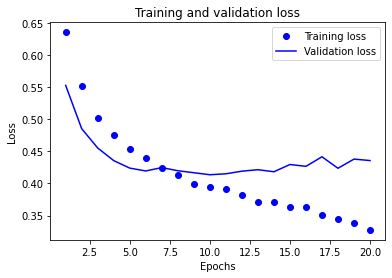

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

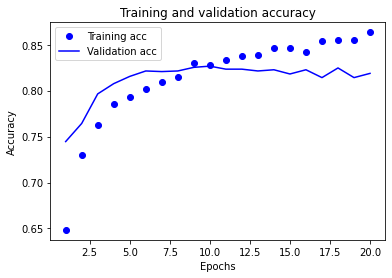

In [16]:
plt.clf() #Очистить рисунок
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
test = pd.read_csv('../input/nlp-getting-started/test.csv')
x_test = pd.DataFrame(test, columns = {'id','text'})
x_test.text = x_test.text.apply(lambda x: remove_noise(x))
x_test.head()
x_test_input = bert_encode(x_test, tokenizer)
x_test_input

{'input_ids': <tf.Tensor: shape=(3263, 100), dtype=int32, numpy=
 array([[   101,  17116,  44936, ...,      0,      0,      0],
        [   101, 107339,  10978, ...,      0,      0,      0],
        [   101,  11155,  10124, ...,      0,      0,      0],
        ...,
        [   101,  13068,  14357, ...,      0,      0,      0],
        [   101,  47430,  11447, ...,      0,      0,      0],
        [   101,  10773,  20324, ...,      0,      0,      0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(3263, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(3263, 100), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0

In [18]:
for key in x_test_input.keys():
    x_test_input[key] = x_test_input[key][:,:SEQ_LEN]

In [19]:
predictions = [np.argmax(i) for i in model.predict(x_test_input)]

In [20]:
submission = test.id.copy().to_frame()
submission['target'] = predictions

In [21]:
submission.to_csv("./submission.csv", index = False)

In [22]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
